In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
files_path = "/content/drive/MyDrive/CV_Assg_2"

In [3]:
! pip3 install tfa-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.7 MB/s 


In [4]:
import glob
from skimage import io, util
from scipy import io as sio
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage import data, io
from matplotlib import pyplot as plt

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import plot_model


import os
import random

import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add

from keras.layers import Input


import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape, Add, Concatenate, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.activations import relu

from tensorflow.keras.metrics import SpecificityAtSensitivity, Precision, Recall, SensitivityAtSpecificity
from tensorflow_addons.metrics import F1Score

from tensorflow.keras import backend as K
!pip install segmentation-models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from tensorflow import keras
sm.set_framework('tf.keras')
sm.framework()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.2 MB/s 
Segmentation Models: using `keras` framework.


'tf.keras'

# **Data Import**

In [5]:
train_dir = glob.glob(f"{files_path}/dataset/train/images_prepped_train/*")
test_dir = glob.glob(f"{files_path}/dataset/test/images_prepped_test/*")

In [6]:
train_mask_dir=os.path.join(files_path+'/dataset/train/annotations_prepped_train')
train_image_dir=os.path.join(files_path+'/dataset/train/images_prepped_train')
test_mask_dir=os.path.join(files_path+'/dataset/test/annotations_prepped_test')
test_image_dir=os.path.join(files_path+'/dataset/test/images_prepped_test')
#Total Number
print('Total Training Images: ',len(os.listdir(train_image_dir)))
print('Total Training Grouth Truth: ',len(os.listdir(train_mask_dir)))
print('Total Test Images: ',len(os.listdir(test_image_dir)))
print('Total Grouth Truth: ',len(os.listdir(test_mask_dir)))
train_image = [os.path.join(train_image_dir,fname) for fname in os.listdir(train_image_dir)[:]]
train_masks = [os.path.join(train_mask_dir,fname) for fname in os.listdir(train_mask_dir)[:]]
test_image = [os.path.join(test_image_dir,fname) for fname in os.listdir(test_image_dir)[:]]
test_masks = [os.path.join(test_mask_dir,fname) for fname in os.listdir(test_mask_dir)[:]]
train_image.sort()
train_masks.sort()
test_image.sort()
test_masks.sort()

Total Training Images:  367
Total Training Grouth Truth:  367
Total Test Images:  101
Total Grouth Truth:  101


In [7]:
from PIL import Image
image_size = (256,256)

#function to load data
def open_image(img):
    return np.array(Image.open(img).resize(image_size, Image.NEAREST))

train_images = np.stack([open_image(i) for i in train_image])
train_masks = np.stack([open_image(i) for i in train_masks])
test_images = np.stack([open_image(i) for i in test_image])
test_masks = np.stack([open_image(i) for i in test_masks])

print('Train Images Shape: ',train_images.shape)
print('Train labels Shape: ',train_masks.shape)
print('Test Images Shape: ',test_images.shape)
print('Test labels Shape: ',test_masks.shape)

Train Images Shape:  (367, 256, 256, 3)
Train labels Shape:  (367, 256, 256)
Test Images Shape:  (101, 256, 256, 3)
Test labels Shape:  (101, 256, 256)


In [8]:
def show(img):
  io.imshow(img)
  plt.show()

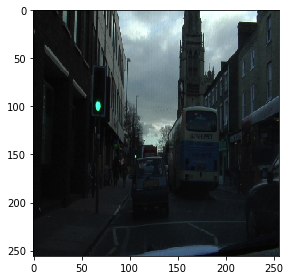

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


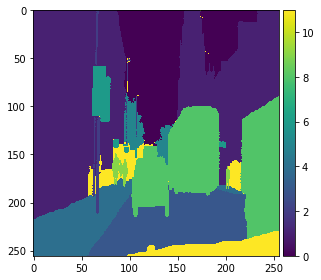

In [9]:
num = 1
show(train_images[num])
show(train_masks[num])

# **Data Augmentation**

In [10]:

from sklearn.model_selection import train_test_split


In [11]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_val.shape)
y_train=np.expand_dims(y_train, -1)
print(y_train.shape)
y_val=np.expand_dims(y_val, -1)
print(y_val.shape)

(275, 256, 256, 3)
(92, 256, 256, 3)
(275, 256, 256, 1)
(92, 256, 256, 1)


In [12]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=20
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

labels_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**labels_data_gen_args)
mask_data_generator.fit(y_train+(1,), augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_val+(1,), seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max'
)

In [26]:
# Visualization
def visualize_scores(nme,results, model):
  plt.figure(figsize=(8, 8))
  plt.title("Learning curve")
  plt.plot(results.history[nme], label=nme)
  plt.plot(results.history[f"val_{nme}"], label=f"val_{nme}")
  if nme == 'loss':
    plt.plot( np.argmin(results.history[f"val_{nme}"]), np.min(results.history[f"val_{nme}"]), marker="x", color="r", label="best model")
  if nme == 'accuracy' or 'iou_score':
    plt.plot( np.argmax(results.history[f"val_{nme}"]), np.max(results.history[f"val_{nme}"]), marker="x", color="r", label="best model")
  plt.xlabel("Epochs")
  plt.ylabel(nme)
  plt.legend();
  plt.show()
  plt.savefig(f'{files_path}/Results/{model}_{nme}.png')


# **UNet_VGG16**

In [15]:
keras.backend.set_image_data_format('channels_last')
model = sm.Unet('vgg16', classes=11, activation='sigmoid', encoder_weights='imagenet')
plot_model(model, to_file=f'{files_path}/unet_vgg_segmentation.png')
model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                             

In [28]:
model.compile(optimizer='Adam',
                   loss=sm.losses.bce_jaccard_loss, metrics=["accuracy",
                                                             sm.metrics.iou_score
                                                            #  dice_coef, 
#                                                         F1Score(3),
                                                        # Precision(),
                                                        # Recall(), 
                                                        # SpecificityAtSensitivity(0.5), 
                                                        # SensitivityAtSpecificity(0.5)
                                                        ])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(f"{files_path}/callbacks/Long.h5", save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # early_stopping
]
batch_size = 32
steps_per_epoch = 3*(len(X_train))//batch_size
epochs = 40
unet_vgg = model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,
                     steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, 
                     callbacks=callbacks)

Epoch 1/40
25/25 [==============================] - 43s 2s/step - loss: -43.3810 - accuracy: 0.2629 - iou_score: 2.9730 - val_loss: -37.9878 - val_accuracy: 0.3338 - val_iou_score: 1.9744 - lr: 0.0010
Epoch 2/40
25/25 [==============================] - 34s 1s/step - loss: -52.8697 - accuracy: 0.3600 - iou_score: 2.8378 - val_loss: -76.4466 - val_accuracy: 0.5833 - val_iou_score: 2.4812 - lr: 0.0010
Epoch 3/40
25/25 [==============================] - 35s 1s/step - loss: -67.0021 - accuracy: 0.3195 - iou_score: 2.6617 - val_loss: -259.2795 - val_accuracy: 0.7766 - val_iou_score: 3.2064 - lr: 0.0010
Epoch 4/40
25/25 [==============================] - 33s 1s/step - loss: -79.3534 - accuracy: 0.3064 - iou_score: 2.7953 - val_loss: -159.8799 - val_accuracy: 0.6963 - val_iou_score: 2.6002 - lr: 0.0010
Epoch 5/40
25/25 [==============================] - 34s 1s/step - loss: -97.5859 - accuracy: 0.3197 - iou_score: 2.9738 - val_loss: -142.2807 - val_accuracy: 0.5986 - val_iou_score: 3.3729 - lr:

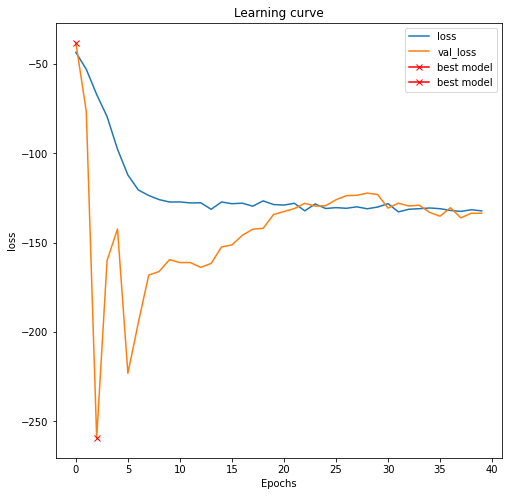

<Figure size 432x288 with 0 Axes>

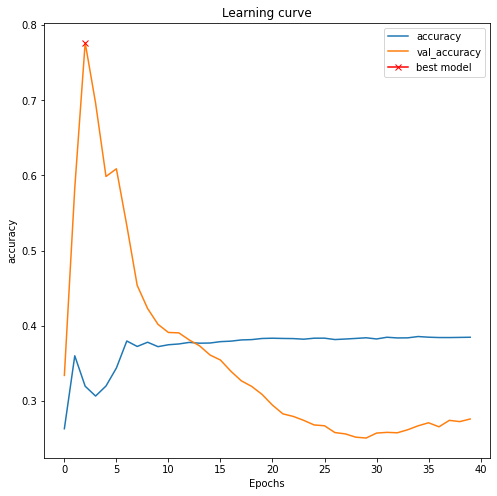

<Figure size 432x288 with 0 Axes>

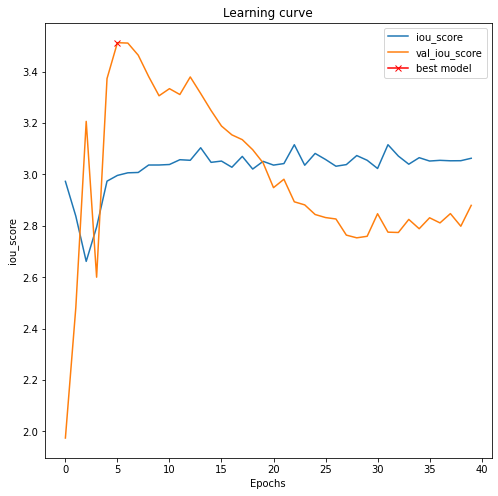

<Figure size 432x288 with 0 Axes>

In [29]:
visualize_scores('loss',unet_vgg, 'unet_vgg')
visualize_scores('accuracy',unet_vgg, 'unet_vgg')
visualize_scores('iou_score',unet_vgg, 'unet_vgg')

# **UNET_ResNet34**

In [18]:
keras.backend.set_image_data_format('channels_last')
model = sm.Unet('resnet34', classes=11, activation='sigmoid', encoder_weights='imagenet')
plot_model(model, to_file=f'{files_path}/unet_resnet34_segmentation.png')
model.summary()

85521592/85521592 [==============================] - 4s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [30]:
model.compile(optimizer='Adam',
                   loss=sm.losses.bce_jaccard_loss, metrics=["accuracy",
                                                             sm.metrics.iou_score
                                                            #  dice_coef, 
#                                                         F1Score(3),
                                                        # Precision(),
                                                        # Recall(), 
                                                        # SpecificityAtSensitivity(0.5), 
                                                        # SensitivityAtSpecificity(0.5)
                                                        ])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(f"{files_path}/callbacks/Long.h5", save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # early_stopping
]
batch_size = 32
steps_per_epoch = 3*(len(X_train))//batch_size
epochs = 40



In [31]:
unet_resnet = model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/40
25/25 [==============================] - 41s 1s/step - loss: -138.0885 - accuracy: 0.3835 - iou_score: 3.0772 - val_loss: -268.4447 - val_accuracy: 0.4123 - val_iou_score: 3.1189 - lr: 0.0010
Epoch 2/40
25/25 [==============================] - 34s 1s/step - loss: -153.8274 - accuracy: 0.4023 - iou_score: 3.0865 - val_loss: -252.7915 - val_accuracy: 0.4546 - val_iou_score: 3.2364 - lr: 0.0010
Epoch 3/40
25/25 [==============================] - 34s 1s/step - loss: -167.5445 - accuracy: 0.4250 - iou_score: 3.0763 - val_loss: -364.1541 - val_accuracy: 0.7016 - val_iou_score: 3.6481 - lr: 0.0010
Epoch 4/40
25/25 [==============================] - 34s 1s/step - loss: -188.3881 - accuracy: 0.4309 - iou_score: 3.1127 - val_loss: -391.9358 - val_accuracy: 0.5037 - val_iou_score: 3.4104 - lr: 0.0010
Epoch 5/40
25/25 [==============================] - 32s 1s/step - loss: -204.5724 - accuracy: 0.4441 - iou_score: 3.0909 - val_loss: -350.3711 - val_accuracy: 0.4711 - val_iou_score: 3.671

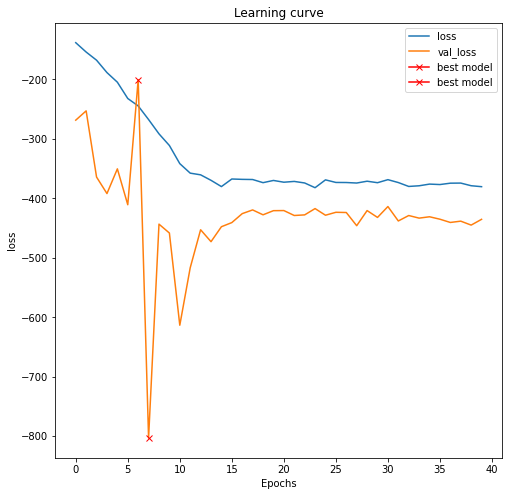

<Figure size 432x288 with 0 Axes>

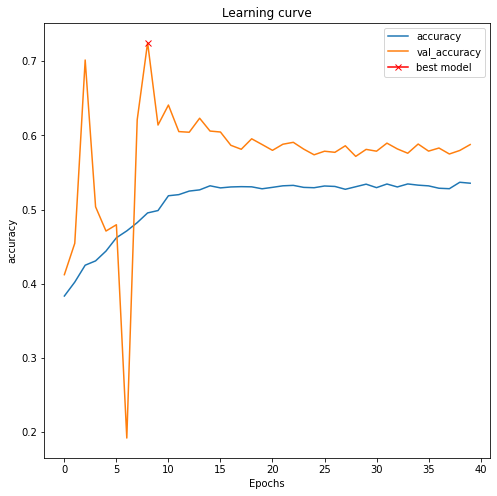

<Figure size 432x288 with 0 Axes>

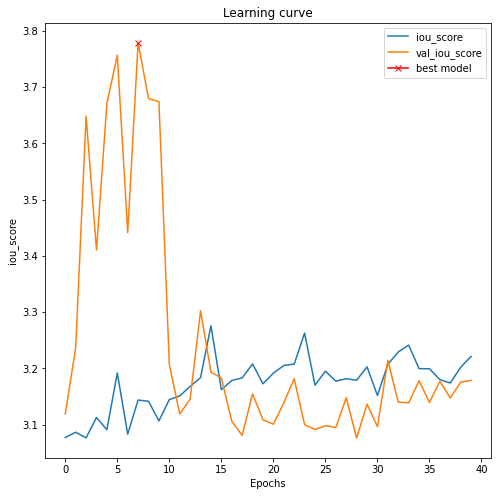

<Figure size 432x288 with 0 Axes>

In [33]:
visualize_scores('loss',unet_resnet,'unet_resnet')
visualize_scores('accuracy',unet_resnet,'unet_resnet')
visualize_scores('iou_score',unet_resnet,'unet_resnet')

# **UNet_MobilwNetV2**

In [34]:
keras.backend.set_image_data_format('channels_last')
model = sm.Unet('mobilenetv2', classes=11, activation='sigmoid', encoder_weights='imagenet')
plot_model(model, to_file=f'{files_path}/unet_mobilenetv2_segmentation.png')

model.summary()

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['Conv1_pad[0][0]']              
                                32)                                                         

In [35]:
model.compile(optimizer='Adam',
                   loss=sm.losses.bce_jaccard_loss, metrics=["accuracy",
                                                             sm.metrics.iou_score
                                                            #  dice_coef, 
#                                                         F1Score(3),
                                                        # Precision(),
                                                        # Recall(), 
                                                        # SpecificityAtSensitivity(0.5), 
                                                        # SensitivityAtSpecificity(0.5)
                                                        ])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(f"{files_path}/callbacks/Long.h5", save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # early_stopping
]
batch_size = 32
steps_per_epoch = 3*(len(X_train))//batch_size
epochs = 40



In [36]:
unet_mobilenet = model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/40
25/25 [==============================] - 42s 1s/step - loss: -2.9855 - accuracy: 0.1114 - iou_score: 1.3585 - val_loss: -76.1857 - val_accuracy: 0.2342 - val_iou_score: 3.6488 - lr: 0.0010
Epoch 2/40
25/25 [==============================] - 34s 1s/step - loss: -11.6720 - accuracy: 0.0792 - iou_score: 2.2334 - val_loss: -345.1958 - val_accuracy: 0.4685 - val_iou_score: 3.3003 - lr: 0.0010
Epoch 3/40
25/25 [==============================] - 32s 1s/step - loss: -21.9024 - accuracy: 0.2027 - iou_score: 2.4333 - val_loss: -152.2253 - val_accuracy: 0.2583 - val_iou_score: 2.4942 - lr: 0.0010
Epoch 4/40
25/25 [==============================] - 32s 1s/step - loss: -33.3640 - accuracy: 0.4697 - iou_score: 2.6080 - val_loss: -27.7760 - val_accuracy: 0.0778 - val_iou_score: 1.1819 - lr: 0.0010
Epoch 5/40
25/25 [==============================] - ETA: 0s - loss: -45.8631 - accuracy: 0.5182 - iou_score: 2.7100
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
25

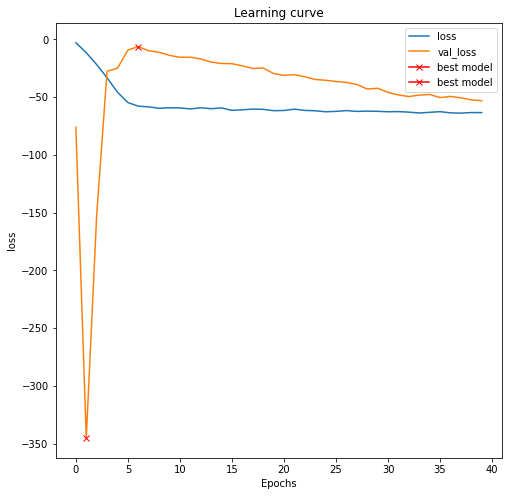

<Figure size 432x288 with 0 Axes>

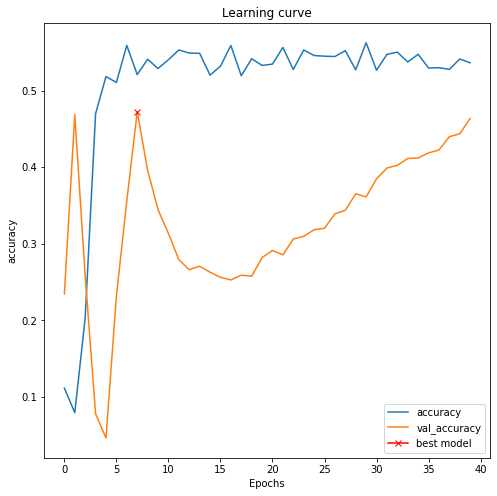

<Figure size 432x288 with 0 Axes>

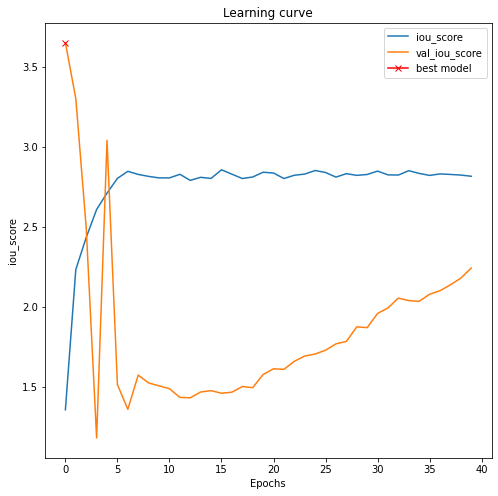

<Figure size 432x288 with 0 Axes>

In [37]:
visualize_scores('loss',unet_mobilenet,'unet_mobilenet')
visualize_scores('accuracy',unet_mobilenet,'unet_mobilenet')
visualize_scores('iou_score',unet_mobilenet,'unet_mobilenet')